<a href="https://colab.research.google.com/github/rj08-97/DSCI644_Project/blob/main/pk/DSCI601Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model Training and Testing 
# Author: Paridhi Khandelwal

import imblearn
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv("DataSetCuratedExtended2020.csv")
print(df)

      Commit A  Commit B  ... CyclomaticStrict  Hit/Dismiss
0     d9545c7f  8f449614  ...        -0.160791            0
1     d9545c7f  8f449614  ...        -0.160791            0
2     d9545c7f  8f449614  ...        -0.160791            0
3     d9545c7f  8f449614  ...        -0.160791            0
4     d9545c7f  8f449614  ...        -0.160791            0
...        ...       ...  ...              ...          ...
6378  b7b744f2  9b669787  ...         0.080176            0
6379  b7b744f2  9b669787  ...         0.080176            0
6380  b7b744f2  9b669787  ...         0.080176            0
6381  b7b744f2  9b669787  ...         0.080176            0
6382  b7b744f2  9b669787  ...         0.080176            0

[6383 rows x 50 columns]


In [ ]:
# oversample the minority class
def count(X):
  zero = 0
  one = 0
  for i in range(len(X)):
    if (X[i] == 0):
      zero += 1
    else:
      one += 1
  print("Zero: " + str(zero))
  print("One: " + str(one) )


In [ ]:
# removing text columns and a row which had boolean FALSE values for all commits
data = df.drop(['Hit/Dismiss'],axis=1).drop(['Commit A'],axis=1).drop(['Commit B'],axis=1).drop(['Benchmark'],axis=1).drop(['Top Chg by Instr >= X%'],axis=1)
# replacing mean value for all non applicable, blank space and  bigger values 
data = data.fillna(data.mean())
# normalize and scale the data
data = preprocessing.normalize(data)
data = preprocessing.scale(data)
oversample = RandomOverSampler(sampling_strategy='minority')
x = data
y = df['Hit/Dismiss'].values
X_over, y_over = oversample.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=40)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Logistic Regression Model training for choosing baseline model with SVM all features
model1 = LogisticRegression()
model1.fit(X_train, y_train)
pred_prob1 = model1.predict_proba(X_test)

In [ ]:
# ROC curve and area under curve value for logistic regression
logit_roc_auc = roc_auc_score(y, model1.predict(x))
fpr, tpr, thresh = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='LR (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# SVM with all features
lf = svm.LinearSVC()
lf.fit(X_over,y_over)
predictions = lf.predict(X_test)
print("Result for SVM")
print('Accuracy {}'.format(lf.score(X_test,y_test)))
print(classification_report(y_test, predictions))
mac = f1_score(y_test, predictions, average='macro')
mic = f1_score(y_test, predictions, average='micro')
wei = f1_score(y_test, predictions, average='weighted')
f1_score = (mac + mic +wei) / 3
print("F1 score: " + str(f1_score))

Result for SVM
Accuracy 0.60610806577917
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1201
           1       0.10      0.67      0.17        76

    accuracy                           0.61      1277
   macro avg       0.53      0.64      0.46      1277
weighted avg       0.91      0.61      0.71      1277

F1 score: 0.5897209694295802


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


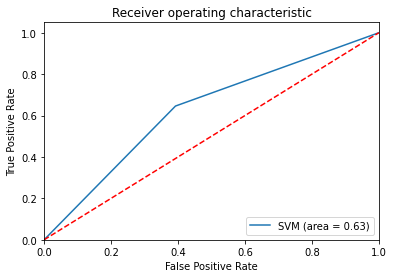

In [ ]:
# ROC curve and area under curve value
logit_roc_auc = roc_auc_score(y, lf.predict(x))
fpr, tpr, thresholds = roc_curve(y, lf.predict(x))
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


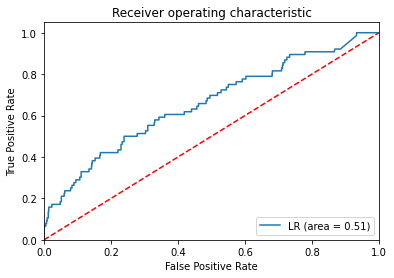

In [ ]:
# SVM with hyperparameter tuning 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.936, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.936, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.936, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.936, total=   0.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.936, total=   0.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.936, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.936, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.936, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.936, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
# print all the best parameters gotten for model
print(grid.best_params_)
# print the model after hyperparameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [ ]:
grid_predictions = grid.predict(X_test)
# printing the results after hyperparameter tuning
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1201
           1       0.93      0.49      0.64        76

    accuracy                           0.97      1277
   macro avg       0.95      0.74      0.81      1277
weighted avg       0.97      0.97      0.96      1277



In [ ]:
# SGDCLassifier Model
clf= SGDClassifier(class_weight="balanced",random_state=1)
clf.fit(X_over, y_over)
predictions = clf.predict(X_test)
# print('Coefficients = ', clf.coef_)
# print('Intercept = ', clf.intercept_)
print("Result for SGD Classifier")
print('Accuracy {}'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, predictions))
from sklearn.metrics import f1_score
f1=0
f1 += f1_score(y_test, predictions, average='macro')
f1 += f1_score(y_test, predictions, average='micro')
f1 += f1_score(y_test, predictions, average='weighted')
f1 = f1/3 
print("F1 score: " + str(f1))

Result for SGD Classifier
Accuracy 0.6217697729052467
              precision    recall  f1-score   support

           0       0.96      0.62      0.76      1201
           1       0.09      0.61      0.16        76

    accuracy                           0.62      1277
   macro avg       0.53      0.61      0.46      1277
weighted avg       0.91      0.62      0.72      1277

F1 score: 0.6000696269324383


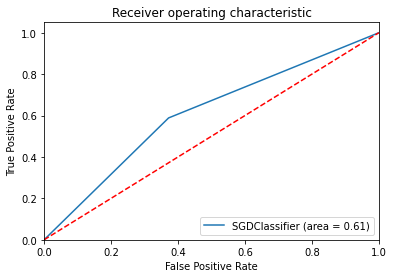

In [ ]:
# ROC curve for SGD Classifier and area under curve value
logit_roc_auc = roc_auc_score(y, clf.predict(x))
fpr, tpr, thresholds = roc_curve(y, clf.predict(x))
plt.figure()
plt.plot(fpr, tpr, label='SGDClassifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.20, random_state=40)

In [ ]:
# hyperparameter tuning for SGDCLassfier but SVM got the best result so we took that one for our final model training
# from sklearn.model_selection import ParameterGrid
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import roc_auc_score
# import parfit.parfit as pf

# grid = {
#     'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
#     'n_iter': [1000], # number of epochs
#     'loss': ['log'], # logistic regression,
#     'penalty': ['l2'],
#     'n_jobs': [-1]
# }
# paramGrid = ParameterGrid(grid)

# bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,X_train, y_train, X_val, y_val,  metric = roc_auc_score, bestScore='max',scoreLabel = "AUC")

# print(bestModel, bestScore)

In [ ]:
# data and columns taken into consideration with feature selection
data = df.drop(['Hit/Dismiss'],axis=1).drop(['Commit A'],axis=1).drop(['Commit B'],axis=1).drop(['Benchmark'],axis=1).drop(['Top Chg by Instr >= X%'],axis=1).drop(['AltCountLineBlank'],axis=1).drop(['AltCountLineCode'],axis=1).drop(['AltCountLineComment'],axis=1).drop(['CountLine'],axis=1).drop(['CountLineBlank'],axis=1).drop(['CountLineCodeExe'],axis=1).drop(['CountLineComment'],axis=1).drop(['CountLineInactive'],axis=1).drop(['CountLinePreprocessor'],axis=1).drop(['CountSemicolon'],axis=1).drop(['CountStmt'],axis=1).drop(['CountStmtDecl'],axis=1).drop(['CountStmtEmpty'],axis=1).drop(['CountStmtExe'],axis=1).drop(['SumCyclomatic'],axis=1).drop(['SumCyclomaticModified'],axis=1).drop(['SumCyclomaticStrict'],axis=1).drop(['SumEssential'],axis=1).drop(['MaxCyclomatic'],axis=1).drop(['MaxCyclomaticModified'],axis=1).drop(['MaxCyclomaticStrict'],axis=1).drop(['AltAvgLineBlank'],axis=1).drop(['AltAvgLineCode'],axis=1).drop(['AltAvgLineComment'],axis=1).drop(['AvgCyclomatic'],axis=1).drop(['AvgCyclomaticModified'],axis=1).drop(['AvgCyclomaticStrict'],axis=1).drop(['AvgLineBlank'],axis=1).drop(['AvgLineComment'],axis=1).drop(['Cyclomatic'],axis=1).drop(['CyclomaticModified'],axis=1).drop(['CyclomaticStrict'],axis=1).drop(['AvgLine'],axis=1).drop(['AvgEssential'],axis=1).drop(['AvgLineCode'],axis=1).drop(['Top Reached Chg Len >= X%'],axis=1).drop(['CountLineCodeDecl'],axis=1)

In [ ]:
# columns selected after the feature selection method(Feature Selection Method done by RJ)
for col in data.columns:
    print(col)

Del Func >= X
New Func >= X
Reached Del Func >= X
Top Chg by Call >= X%
Top > X% by Call Chg by >= 10%
Top Chg Len >= X%
CountLineCode
MaxNesting


In [ ]:
# data preprocessing
data = preprocessing.normalize(data)
data = preprocessing.scale(data)
oversample = RandomOverSampler(sampling_strategy='minority')
x = data
y = df['Hit/Dismiss'].values
X_over, y_over = oversample.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# SVM trained with feature selected 
lf = svm.LinearSVC()
lf.fit(X_over,y_over)
predictions = lf.predict(X_test)
print("Result for SVM")
print('Accuracy {}'.format(lf.score(X_test,y_test)))
# print('Confusion = {}'.format(metrics.confusion_matrix(predictions, y_test, [0,1])))
print(classification_report(y_test, predictions))
# print('Actual hit(Training)   ', y_train)
# mac = f1_score(y_over, predictions, average='macro')
# mic = f1_score(y_over, predictions, average='micro')
# wei = f1_score(y_over, predictions, average='weighted')
# f1_score = (mac + mic +wei)/3
# print("F1 score: " + str(f1_score))
mac = f1_score(y_test, predictions, average='macro')
mic = f1_score(y_test, predictions, average='micro')
wei = f1_score(y_test, predictions, average='weighted')
f1_score = (mac + mic +wei)/3
print("F1 score: " + str(f1_score))

Result for SVM
Accuracy 0.4839467501957713
              precision    recall  f1-score   support

           0       0.95      0.48      0.63      1201
           1       0.07      0.62      0.12        76

    accuracy                           0.48      1277
   macro avg       0.51      0.55      0.38      1277
weighted avg       0.90      0.48      0.60      1277

F1 score: 0.48906458879832354


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


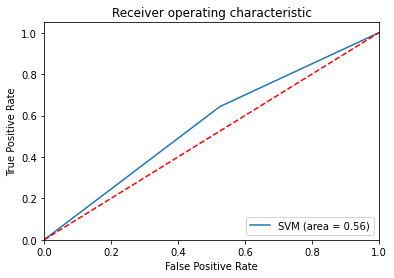

In [ ]:
# ROC curve and area uder curve value 
logit_roc_auc = roc_auc_score(y, lf.predict(x))
fpr, tpr, thresholds = roc_curve(y, lf.predict(x))
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# SGDClassifier with feature selection method
clf= SGDClassifier(class_weight="balanced",random_state=1)
clf.fit(X_over, y_over)
predictions = clf.predict(X_test)
# print('Coefficients = ', clf.coef_)
# print('Intercept = ', clf.intercept_)
print("Result for SGD Classifier")
print('Accuracy {}'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, predictions))
from sklearn.metrics import f1_score
f1=0
f1 += f1_score(y_test, predictions, average='macro')
f1 += f1_score(y_test, predictions, average='micro')
f1 += f1_score(y_test, predictions, average='weighted')
f1 = f1/3 
print("F1 score: " + str(f1))

Result for SGD Classifier
Accuracy 0.6147220046985121
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1201
           1       0.08      0.53      0.14        76

    accuracy                           0.61      1277
   macro avg       0.52      0.57      0.45      1277
weighted avg       0.90      0.61      0.72      1277

F1 score: 0.5919612190478333


In [ ]:
# logistic regression with feature selection method
model1 = LogisticRegression()
model1.fit(X_train, y_train)
pred_prob1 = model1.predict_proba(X_test)

In [ ]:
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
print(auc_score1)

0.5625410841842323


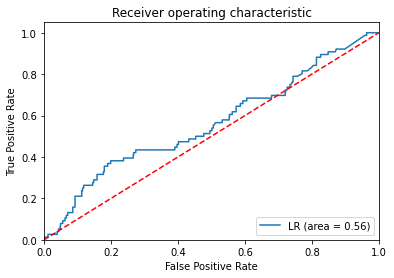

In [ ]:
# ROC curve for logistic regression with feature selected
logit_roc_auc = roc_auc_score(y, model1.predict(x))
fpr, tpr, thresh = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='LR (area = %0.2f)' % auc_score1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()